In [1]:
import os

os.environ["GROQ_API_KEY"] = "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"
os.environ["TAVILY_API_KEY"] = "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"

/var/folders/36/1q0jwbc57bg77709s9zkjv100000gn/T/ipykernel_33251/87943435.py:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/Users/yegyanathanv/anaconda3/envs/chatapp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


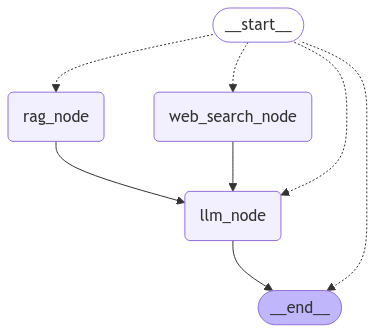

In [2]:
from langchain_groq import ChatGroq
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_milvus import Milvus
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from typing import Optional

# Define State Class
class ChatState(BaseModel):
    query: str = ""
    has_document: bool = False
    do_web_search: bool = False
    rag_context: Optional[str] = ""
    web_context: Optional[str] = ""
    response: Optional[str] = ""

# Initialize LangChain components
llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_db = Milvus(
    embedding_function=embeddings,
    connection_args={"uri": "./milvus_example.db"},
    # Set index_params if needed
    index_params={"index_type": "FLAT", "metric_type": "L2"},
    auto_id=True
)
web_search = TavilySearchResults(
    max_results=1,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

# Routing Function
def routing_function(state: ChatState):
    if state.has_document and state.do_web_search:
        return ["rag_node", "web_search_node"]
    elif state.has_document:
        return ["rag_node"]
    elif state.do_web_search:
        return ["web_search_node"]
    else:
        return ["llm_node"]

# RAG Node
def rag_node(state: ChatState) -> ChatState:
    """Retrieve context from vector database."""
    context_results = vector_db.similarity_search(state.query, k=3)
    context_text = "\n".join([doc.page_content for doc in context_results])
    return {"rag_context": context_text}

# Web Search Node
def web_search_node(state: ChatState) -> ChatState:
    """Retrieve context from web search."""
    search_results = web_search.run(state.query)[0]['content']
    return {"web_context": search_results}

# LLM Node
def llm_node(state: ChatState) -> ChatState:
    """Generate final response using LLM."""
    prompt = f"""
    Answer the question based on the provided contexts.
    
    RAG Context: 
    {state.rag_context}
    Web Context: 
    {state.web_context}
    
    Query: {state.query}
    """
    response = llm.invoke(prompt).content
    return {"response": response}

# Build the LangGraph workflow
graph = StateGraph(ChatState)
graph.add_node("rag_node", rag_node)
graph.add_node("web_search_node", web_search_node)
graph.add_node("llm_node", llm_node)

# Define edges
graph.add_conditional_edges(START, routing_function)
graph.add_edge("rag_node", "llm_node")
graph.add_edge("web_search_node", "llm_node")
graph.add_edge("llm_node", END)  # Ensure LLM output leads to END

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Compile Graph
compiled_graph = graph.compile(checkpointer=memory)

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# initial_state = ChatState(
#     query="can you find where i work currently in my resume?",
#     do_web_search=True,
#     has_document=True
# )

# config = {"configurable": {"thread_id": "1"}}
# result = compiled_graph.invoke(initial_state, config=config)
# print(result['response'])

# config = {"configurable": {"thread_id": "1"}}
# compiled_graph.invoke(ChatState(
#     query="what was my last question?",
#     do_web_search=False,
#     has_document=False
# ), config=config)['response']


In [3]:
initial_state = ChatState(
    query="can you find where i work currently in my resume?",
    do_web_search=True,
    has_document=True
)

config = {"configurable": {"thread_id": "1"}}
result = compiled_graph.invoke(initial_state, config=config)
result['response']

'Based on the provided context, the information about where you currently work on your resume would typically be found in the "Work Experience" section. It should be listed as a current job, using the present tense to describe your responsibilities and duties. This helps employers understand your current employment status and the role you are currently in.'

In [ ]:

config = {"configurable": {"thread_id": "1"}}
compiled_graph.invoke(ChatState(
    query="what was my last question?",
    do_web_search=False,
    has_document=False
), config=config)['response']

In [ ]:
config = {"configurable": {"thread_id": "1"}}
compiled_graph.get_state(config)

In [ ]:
config = {"configurable": {"thread_id": "1"}}
list(compiled_graph.get_state_history(config))

In [ ]:
memory = MemorySaver()

compiled_graph = graph.compile(checkpointer=memory)

def invoke_conversation(query, thread_id):
    """Handles new and ongoing conversations based on thread_id."""
    
    initial_state = ChatState(query=query, do_web_search=True, has_document=False)

    config = {"configurable": {"thread_id": thread_id}}
    result = compiled_graph.invoke(initial_state, config=config)
    
    return result["response"]

# Example Usage:
# Start a new conversation
thread_1 = "thread_123"
response = invoke_conversation("What is LangGraph?", thread_1)
print(response)

# Continue the same thread
response = invoke_conversation("How does it handle memory?", thread_1)
print(response)

# Start a new conversation thread
thread_2 = "thread_456"
response = invoke_conversation("Tell me about transformers in NLP.", thread_2)
print(response)


In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = "hi! I'm bob"
for event in compiled_graph.stream({"query": input_message}, config, stream_mode="values"):
    event["response"].pretty_print()


input_message = "what's my name?"
for event in compiled_graph.stream({"query": input_message}, config, stream_mode="values"):
    event["response"].pretty_print()